In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import os
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate
import scipy
from scipy.fft import fft, rfft, irfft,ifft,fftfreq
import wget,requests
from scipy.interpolate import LinearNDInterpolator


nist_table_dir="./NistData"


#### Getting isobar data from nist 

In [2]:
Pressure=1
TempHigh=300
TempLow=270
TempStep=1


for Pressure in np.arange(0.1,900.1,25):
    fname="NistData-isobar-P%0.2f-HighT%0.2f-LowT%0.2f-Step%0.2f.tsv"%(Pressure,TempHigh,TempLow,TempStep)
    filepath="./NistData/%s"%(fname)
    #print("https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoBar&Digits=5&P=%0.2f&THigh=%0.2f&TLow=%0.2f&TInc=%0.2f&RefState=DEF&TUnit=K&PUnit=psia&DUnit=g%%2Fml&HUnit=kJ%%2Fmol&WUnit=m%%2Fs&VisUnit=uPa*s&STUnit=N%%2Fm"%(Pressure,TempHigh,TempLow,TempStep))
    if os.path.exists(filepath):
        print("Skipping %s, already exisis"%(filepath))
    else:
        url ="https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoBar&Digits=5&P=%0.2f&THigh=%0.2f&TLow=%0.2f&TInc=%0.2f&RefState=DEF&TUnit=K&PUnit=psia&DUnit=g%%2Fml&HUnit=kJ%%2Fmol&WUnit=m%%2Fs&VisUnit=uPa*s&STUnit=N%%2Fm"%(Pressure,TempHigh,TempLow,TempStep)
        file=wget.download(url,filepath )

Skipping ./NistData/NistData-isobar-P0.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P25.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P50.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P75.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P100.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P125.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P150.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P175.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P200.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P225.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P250.10-H

In [3]:
files = glob.glob(nist_table_dir+"/*isobar-P[0-30]*LowT[161]*")
print(files)

[]


### Isobar

#### Read in isobar data to XeTable for Cell

In [4]:
files = glob.glob(nist_table_dir+"/*isobar-P[0-30]*LowT[161]*")
DFs=[]
Ps=[]
Ts=[]
Ds=[]
for file in files:
    DF= pd.read_table(file)
    DFs.append(DF)
    Ps.append(DF["Pressure (psia)"][:].values)
    Ts.append(DF["Temperature (K)"][:].values)
    Ds.append(DF["Density (g/ml)"][:].values)


XeTable=pd.concat(DFs,ignore_index=True)
XeTable = XeTable.sort_values(by=["Pressure (psia)","Temperature (K)"])


ValueError: No objects to concatenate

#### Set up 2d interpolation

In [ ]:
X=np.array(XeTable["Temperature (K)"])
Y=np.array(XeTable["Pressure (psia)"])
Z=np.array(XeTable["Density (g/ml)"])
IsoBar_TvP=LinearNDInterpolator(list(zip(X,Y)),Z)

NameError: name 'XeTable' is not defined

#### colorbar map of density for PvT  cmap is log scale

In [ ]:
Tmin=160
Tmax=185
Pmin=13
Pmax=28
count=5

print("abs(`Temperature (K)` -%f) <%f and abs(`Pressure (psia)` - %f) <%f"%((Tmin+Tmax)/2, (Tmax-Tmin)/2,(Pmax+Pmin)/2,(Pmax-Pmin)/1.99))
DF=XeTable.query("abs(`Temperature (K)` -%f) <%f and abs(`Pressure (psia)` - %f) <%f"%((Tmin+Tmax)/2, (Tmax-Tmin)/2,(Pmax+Pmin)/2,(Pmax-Pmin)/1.99))

plt.scatter(DF["Temperature (K)"],DF["Pressure (psia)"],c=(DF["Density (g/ml)"]),marker=".",cmap="jet")
plt.colorbar()


for i in np.arange(0,count+1,1):
    x=np.random.random()*(Tmax-Tmin)+Tmin
    y=np.random.random()*(Pmax-Pmin)+Pmin
    z=IsoBar_TvP(x,y)
    print(x,y,z)

    plt.text(x,y,np.round(z,5),color="red")
    plt.scatter(x,y,c=z,marker="x")


for m in [0,1,2,3,4,5,6]:
    m= int(m/6* len(DF.index)) -1
    X=DF["Temperature (K)"].iloc[m]
    Y=DF["Pressure (psia)"].iloc[m]
    Z=DF["Density (g/ml)"].iloc[m]
    plt.text(X-0.15,Y-0.015,np.round(Z,4))
    




abs(`Temperature (K)` -172.500000) <12.500000 and abs(`Pressure (psia)` - 20.500000) <7.537688


NameError: name 'XeTable' is not defined

In [ ]:
IsoBar_TvP(293,525)

NameError: name 'IsoBar_TvP' is not defined

#### Read in isobar data to XeTable for Storage

In [5]:
files = glob.glob(nist_table_dir+"/*isobar*LowT[270]*")
DFs=[]
Ps=[]
Ts=[]
Ds=[]
for file in files:
    DF= pd.read_table(file)
    DFs.append(DF)
    Ps.append(DF["Pressure (psia)"][:].values)
    Ts.append(DF["Temperature (K)"][:].values)
    Ds.append(DF["Density (g/ml)"][:].values)


XeTable_storage=pd.concat(DFs,ignore_index=True)
XeTable_storage = XeTable_storage.sort_values(by=["Pressure (psia)","Temperature (K)"])


In [6]:
X=np.array(XeTable_storage["Temperature (K)"])
Y=np.array(XeTable_storage["Pressure (psia)"])
Z=np.array(XeTable_storage["Density (g/ml)"])
IsoBar_TvP_storage=LinearNDInterpolator(list(zip(X,Y)),Z)

abs(`Temperature (K)` -295.000000) <5.000000 and abs(`Pressure (psia)` - 287.500000) <238.693467


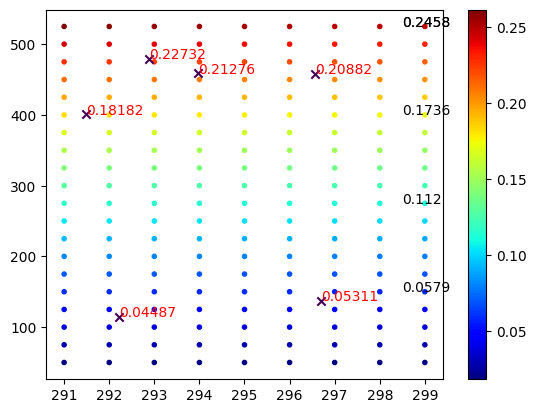

In [8]:
Tmin=290
Tmax=300
Pmin=50
Pmax=525
count=5

Storage_vol=7570.82 +300## Storage volume in ml

print("abs(`Temperature (K)` -%f) <%f and abs(`Pressure (psia)` - %f) <%f"%((Tmin+Tmax)/2, (Tmax-Tmin)/2,(Pmax+Pmin)/2,(Pmax-Pmin)/1.99))
DF=XeTable_storage.query("abs(`Temperature (K)` -%f) <%f and abs(`Pressure (psia)` - %f) <%f"%((Tmin+Tmax)/2, (Tmax-Tmin)/2,(Pmax+Pmin)/2,(Pmax-Pmin)/1.99))

plt.scatter(DF["Temperature (K)"],DF["Pressure (psia)"],c=(DF["Density (g/ml)"]),marker=".",cmap="jet")
plt.colorbar()


for i in np.arange(0,count+1,1):
    x=np.random.random()*(Tmax-Tmin)+Tmin
    y=np.random.random()*(Pmax-Pmin)+Pmin
    z=IsoBar_TvP_storage(x,y)
    
    
    plt.text(x,y,np.round(z,5),color="red")
    plt.scatter(x,y,c=z,marker="x")


for m in [0,1,2,3,4]:
    m= int(m/4* len(DF.index)) -1
    X=DF["Temperature (K)"].iloc[m]
    Y=DF["Pressure (psia)"].iloc[m]
    Z=DF["Density (g/ml)"].iloc[m]

    
    plt.text(X-0.5,Y-0.025,np.round(Z,4))
    




## Amount of Xenon in Storage clyinder with P and T

In [9]:
## Set the time 0 amount of xenon

x=293
y=675+14.7
z=IsoBar_TvP_storage(x,y)

print( "Xe Mass in Storage at %0.3f psia(%0.3f psig) and %0.3f K is %0.3f grams:"%(y,y-14.7,x,z*Storage_vol))

XeMass_t0=z*Storage_vol
print(XeMass_t0)

Xe Mass in Storage at 689.700 psia(675.000 psig) and 293.000 K is 3114.680 grams:
3114.6799296672


Xenon Mass in Storage as of 20240618 @ 1515 is 2076.88 grams, @ 294.65 K and 540 psig

## Amount of Xenon removed from storage.


In [88]:
x=293 #temp
y=600+14.7 #pressure
z=IsoBar_TvP_storage(x,y)

XeMass_removed= XeMass_t0 - z*Storage_vol

print( "Xe Mass in Storage at %0.3f psia(%0.3f psig) and %0.3f K is %0.3f grams:"%(y,y-14.7,x,z*Storage_vol))

print( "Xe Mass removed from storage at %0.3f psia(%0.3f psig) and %0.3f K is %0.3f grams:"%(y,y-14.7,x,XeMass_removed))


Xe Mass in Storage at 614.700 psia(600.000 psig) and 293.000 K is 2560.042 grams:
Xe Mass removed from storage at 614.700 psia(600.000 psig) and 293.000 K is 554.638 grams:


In [32]:
np.sqrt(150**2+ 70**2)

165.5294535724685

## 20241004

In [34]:
def getperrors(pressures):
    
    p_low=[]
    p_high=[]

    for p in pressures:
        p_floor= np.floor(p/100)*100
        p_ceil= np.ceil(p/100)*100

        if p%50==0:
            p_range=[p-15,p,p+15]
        elif p%25==0:
            p_range=[p-20,p,p+20]
        elif p-p_floor < 6:
            p_range=[np.max([p_floor-5,p-25]),p,np.min([p+25,p_floor+50])]
        elif p-p_floor < 50:
            p_range=[np.max([p_floor,p-25]),p,np.min([p+25,p_floor+50])]
        else:
            p_range=[np.max([p_ceil-50,p-25]),p,np.min([p_ceil,p+25])]
        
        p_low.append(p_range[0])
        p_high.append(p_range[2])
        print(p_range)
    return p_low,p_high


def GetMassInjected(p,T=293,m_0=XeMass_t0,vol=Storage_vol):
    
    if type(p) == type([]):
        m_inj=[]
        for pre in p:
            m_inj.append(m_0 -IsoBar_TvP_storage(T,pre+14.7)*vol )
        return m_inj
    else:
        m_in_sto_t = IsoBar_TvP_storage(T,p+14.7)*vol
        return m_0-m_in_sto_t


    




### Feb 25th


In [11]:
Feb04_p= np.array([675,650])
time_0204 = np.array([10+5/6,11])
p_low_0204,p_high_0204= getperrors(Feb04_p)


m_low_0204= GetMassInjected(p_low_0204)
m_high_0204=GetMassInjected(p_high_0204)
m_0204=GetMassInjected(Feb04_p)

m_err_0204=np.vstack((np.abs(m_high_0204-m_0204),m_low_0204-m_0204))

print(m_0204)

[655, 675, 695]
[635, 650, 665]
[  0.         199.29357006]


In [12]:
Jan28_p= np.array([675,600,575,550,525,500,480,450,400])
time_0128 = np.array([8+35/60,8.75,9.00,9.25,9.5,9.75,10.0,10.25,10+35/60])
p_low_0128,p_high_0128= getperrors(Jan28_p)


m_low_0128= GetMassInjected(p_low_0128)
m_high_0128=GetMassInjected(p_high_0128)
m_0128=GetMassInjected(Jan28_p)

m_err_0128=np.vstack((np.abs(m_high_0128-m_0128),m_low_0128-m_0128))

print(m_0128)

[655, 675, 695]
[585, 600, 615]
[555, 575, 595]
[535, 550, 565]
[505, 525, 545]
[485, 500, 515]
[455.0, 480, 500.0]
[435, 450, 465]
[385, 400, 415]
[   0.          554.6384251   715.2031531   866.48598049 1009.69397622
 1145.85034691 1250.46802701 1399.99345772 1633.92682143]


In [13]:
pressures = np.array([600,550,535,500,485,475,450,410,375,360])
p_low,p_high= getperrors(pressures)


m_low= GetMassInjected(p_low)
m_high=GetMassInjected(p_high)
m=GetMassInjected(pressures)

m_err=np.vstack((np.abs(m_high-m),m_low-m))


[585, 600, 615]
[535, 550, 565]
[510.0, 535, 550.0]
[485, 500, 515]
[460.0, 485, 500.0]
[455, 475, 495]
[435, 450, 465]
[400.0, 410, 435.0]
[355, 375, 395]
[350.0, 360, 385.0]


In [14]:
time_1213 = np.array([8.50,8 +5/6,9,9.25,9.5,9+5/6,10 + 1/12,10.25,10+25/60])
pressures_1213 = np.array([600,540,500,475,450,425,400,375,365])
p_low_1213,p_high_1213= getperrors(pressures_1213)


m_low_1213= GetMassInjected(p_low_1213)
m_high_1213=GetMassInjected(p_high_1213)
m_1213=GetMassInjected(pressures_1213)

m_err_1213=np.vstack((np.abs(m_high_1213-m_1213),m_low_1213-m_1213))


[585, 600, 615]
[515.0, 540, 550.0]
[485, 500, 515]
[455, 475, 495]
[435, 450, 465]
[405, 425, 445]
[385, 400, 415]
[355, 375, 395]
[350.0, 365, 390.0]


In [15]:
type(np.array(p_low))

numpy.ndarray

In [16]:
mass_removed_6 = [550]
time_6 = np.array([8.75] )##20241203

mass_removed_5 = [554,866,954,1145,1225,1275,1400,1590]
time_5 = np.array([8.5,9,9.25,9.5,9.75,10,10.5,11,11.5,12] )##20241203

mass_removed_4 = [199.3,383,550,808,981,1092,1145,1250,1400,1520,1633,1744]
time_4 = np.array([8.5, 8+35/60, 8+5/6, 9.25,9.75,9+57/60,10+1/6,10.5,10+5/6,11+1/6,11+35/60,11+5/6 ])  ##20241025

mass_removed_3 = [554.6,808,925,1145.9,1250,1350]
time_3 = np.array([9 +12/60, 9+25/60,9+5/6,10+1/6,10+23/60,10+35/60])  ##20241011

mass_removed_2 = [554.6378,866,1093,1200,1400,1448,1634, 1810]
time_2 = np.array([9 +11/60,9 +41/60, 10.0,10.5,10 + 40/60, 11 +10/60, 11.5, 12 ])  ##20241004

mass_removed = [199.3,555,684,866,1145,1200]
time = np.array([10+23/60,10 + 37/60,10.75,11 +5/60,11.75,11+55/60])  ## 20241007

In [17]:
Feb04_p= np.array([675,650,575,550,535,500,485,450,405])
time_0204 = np.array([10+5/6,11,11.5,11.75,12,12.25,12.5,12+5/6,13+5/9])
p_low_0204,p_high_0204= getperrors(Feb04_p)


m_low_0204= GetMassInjected(p_low_0204)
m_high_0204=GetMassInjected(p_high_0204)
m_0204=GetMassInjected(Feb04_p)

m_err_0204=np.vstack((np.abs(m_high_0204-m_0204),m_low_0204-m_0204))

print(m_0204)

[655, 675, 695]
[635, 650, 665]
[555, 575, 595]
[535, 550, 565]
[510.0, 535, 550.0]
[485, 500, 515]
[460.0, 485, 500.0]
[435, 450, 465]
[400.0, 405, 430.0]
[   0.          199.29357006  715.2031531   866.48598049  954.1574703
 1145.85034691 1225.18695317 1399.99345772 1611.49498443]


## 20250225

In [35]:
Feb25_p= np.array([675,650,600,550,525,500,475,450,425,405])
time_0225 = np.array([9,9+1/6,9.5,10,10.33,10+5/6,11+1/6,11.33,11+5/6,12])
p_low_0225,p_high_0225= getperrors(Feb25_p)


m_low_0225= GetMassInjected(p_low_0225)
m_high_0225=GetMassInjected(p_high_0225)
m_0225=GetMassInjected(Feb25_p)

m_err_0225=np.vstack((np.abs(m_high_0225-m_0225),m_low_0225-m_0225))

m_0225

[655, 675, 695]
[635, 650, 665]
[585, 600, 615]
[535, 550, 565]
[505, 525, 545]
[485, 500, 515]
[455, 475, 495]
[435, 450, 465]
[405, 425, 445]
[395.0, 405, 430.0]


array([   0.        ,  199.29357006,  554.6384251 ,  866.48598049,
       1009.69397622, 1145.85034691, 1275.74910085, 1399.99345772,
       1519.23952904, 1611.49498443])

## 20250311

In [40]:
Mar11_p= np.array([675,600,550,500,485,450,400])
time_0311 = np.array([9,9.5,10,10.5,11,11.5,12.1])
p_low_0311,p_high_0311= getperrors(Mar11_p)


m_low_0311= GetMassInjected(p_low_0311)
m_high_0311=GetMassInjected(p_high_0311)
m_0311=GetMassInjected(Mar11_p)

m_err_0311=np.vstack((np.abs(m_high_0311-m_0311),m_low_0311-m_0311))



print(m_0311)

m_err_0311_new=np.array([(m_err_0311[0][1:],m_err_0311[1][1:])])


[655, 675, 695]
[585, 600, 615]
[535, 550, 565]
[485, 500, 515]
[460.0, 485, 500.0]
[435, 450, 465]
[385, 400, 415]
[   0.          554.6384251   866.48598049 1145.85034691 1225.18695317
 1399.99345772 1633.92682143]


## Plot

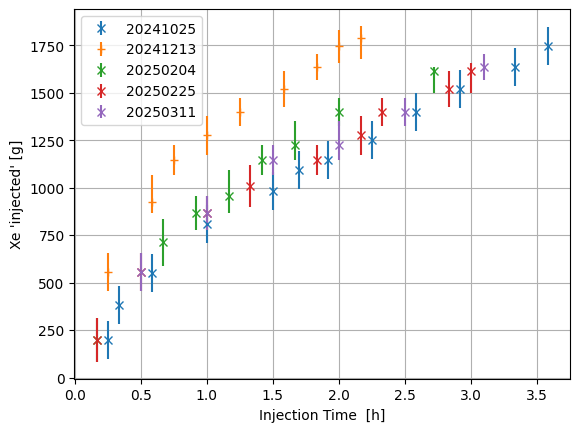

In [41]:
m_err_0128_new=np.array([(m_err_0128[0][1:],m_err_0128[1][1:])])
m_err_0204_new=np.array([(m_err_0204[0][1:],m_err_0204[1][1:])])
m_err_0225_new=np.array([(m_err_0225[0][1:],m_err_0225[1][1:])])
#  plt.errorbar(x=time-time[0], y=mass_removed,yerr=100,fmt=" ", marker="o",label="20241007")
# plt.errorbar(x=time_2-time_2[0], y=mass_removed_2,yerr=100,fmt=" ", marker="x", label="20241004")
# plt.errorbar(x=time_3-time_3[0], y=mass_removed_3,yerr=100,fmt=" ", marker="x", label="20241011")


plt.errorbar(x=time_4-(8.25), y=mass_removed_4,yerr=100,fmt=" ", marker="x", label="20241025")
#plt.errorbar(x=time_5-(8.25), y=mass_removed_5,yerr=100,fmt=" ", marker="+", label="20241203")
#plt.errorbar(x=time_5-(8.25), y=m,yerr=m_err,fmt=" ", marker="*", label="20241203")
plt.errorbar(x=time_1213-(8.25) , y =m_1213, yerr=m_err_1213,fmt=" ",marker="+",label="20241213")
#plt.errorbar(x=time_0128[1:]-time_0128[0] , y =m_0128[1:], yerr=m_err_0128_new[0],fmt=" ",marker="+",label="20250128")
plt.errorbar(x=time_0204[1:]-time_0204[0] , y =m_0204[1:], yerr=m_err_0204_new[0],fmt=" ",marker="x",label="20250204")
plt.errorbar(x=time_0225[1:]-time_0225[0] , y =m_0225[1:], yerr=m_err_0225_new[0],fmt=" ",marker="x",label="20250225")
plt.errorbar(x=time_0311[1:]-time_0311[0] , y =m_0311[1:], yerr=m_err_0311_new[0],fmt=" ",marker="x",label="20250311")

plt.grid()
plt.ylabel("Xe 'injected' [g]")
plt.xlabel("Injection Time  [h]")
plt.legend()

## Estimate Volmne of Cell

### Cupper Cell

In [53]:
Cu_Cell_H =215.9 #mm
Cu_Cell_ID=99.949  #mm
Cu_Cell_vol= Cu_Cell_H * (Cu_Cell_ID/2)**2 * np.pi
Cu_Cell_vol

1693945.4876925927

### Stainless Steal Nipple

In [54]:
SS_Nipple_H  = 134.874#mm
SS_Nipple_ID = 100#mm This is the OD 
SS_Nipple_vol= SS_Nipple_H * (SS_Nipple_ID/2)**2 * np.pi
SS_Nipple_vol

1059297.9189006744

### Cross

In [55]:
Cross_large_ID = 72.898 #mm 76.2 OD guess at ID from standard chart
Cross_large_len= 85.852*2#mm
Cross_small_ID = 60.198 #mm 63.5 OD guess at ID from standard chart
Cross_small_len= 75.184*2#mm

Cross_small_overlap_vol = Cross_large_ID * (Cross_small_ID/2)**2 * np.pi

Cross_vol = Cross_large_len * ( Cross_large_ID/2)**2 * np.pi + Cross_small_len* (Cross_small_ID/2)**2 * np.pi - Cross_small_overlap_vol
Cross_vol


937130.1069842934

### Tubing and Extras

In [56]:
Tubing_len=500 #mm rough estimate measuring tubes on top of cryo
Tubing_ID=4.572 #1/4 OD estimate of ID via standard chart

Tubing_vol=Tubing_len* (Tubing_ID/2)**2 * np.pi
Tubing_vol

8208.661161379463

### Total Vol

In [57]:
Total_Xenon_Vol= SS_Nipple_vol+ Cu_Cell_vol+Cross_vol+Tubing_vol+300000
Total_Xenon_Vol #cubim mm

print("Total xenon vol is %0.3f ml"%(Total_Xenon_Vol*0.001))

Total xenon vol is 3998.582 ml


In [58]:
#Estimate extra vol as extra heigth on cell

Extra_Vol_fakeH =(Cross_vol+Tubing_vol+300000)/(Cu_Cell_ID/2)**2 #,,

Vol_Other= (Extra_Vol_fakeH + SS_Nipple_H)*(SS_Nipple_ID/2)**2 *0.001
print(Vol_Other, " Vol other ml")


1583.7949860882256  Vol other ml


In [59]:
np.pi *((3.5/2)**2-(3/2)**2) *12 * 16.3871  #+ np.pi *((2/2)**2-(1/2)**2) *6 * 16.3871 

501.9455314930027

In [60]:
CubeVol_withhole = 3.5*3.5*12 *16.3871  - (np.pi * (0.8/2)**2 * 12 *16.3871)

ppv=CubeVol_withhole/120

print(CubeVol_withhole,ppv)

2310.0590414906087 19.250492012421738


In [61]:
CubeVol_withhole = 3.5*3.5*3.5 *16.3871  - np.pi * (0.8/2)**2 * 3.5 *16.3871

ppv=CubeVol_withhole/59

print(CubeVol_withhole,ppv)

673.7672204347609 11.419783397199337


In [62]:
np.pi*(3.75/2)**2 * 6 * 16.3871 , np.pi*(3.75/2)**2 * 6 * 16.3871/130 , 2.7*np.pi*(3.75/2)**2 * 6 * 16.3871

(1085.9398517877462, 8.353383475290356, 2932.0375998269146)

In [63]:
0.0054178*100*1000/1000

0.54178

## Density in Cell

In [72]:
mass=2850#XeMass_removed
XeCell_Density = mass/(Total_Xenon_Vol*0.001) # g/ml
XeCell_Density


0.7127526396743544

### Grab isochoric data for heigth estimate

In [70]:
XeDensity=XeCell_Density
THigh=300
TLow=161
TStep=0.25


IsoChoric_URL="https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoChor&Digits=5&THigh=%0.3f&TLow=%0.3f&TInc=%0.3f&D=%0.3f&RefState=DEF&TUnit=K&PUnit=psia&DUnit=g%%2Fml&HUnit=kJ%%2Fmol&WUnit=m%%2Fs&VisUnit=uPa*s&STUnit=N%%2Fm"%(THigh,TLow,TStep,XeDensity)
IsoChoric_filename="NistData-isochoric-D%0.4f-TLow%0.3f-THigh%0.3f-Tstep%0.3f.tsv"%(XeDensity,TLow,THigh,TStep)

filepath="./NistData/%s"%(IsoChoric_filename)
if os.path.exists(filepath):
    print("Skipping %s, already exisis"%(filepath))
    file = open(filepath)
else:
    print("Getting new file with Density if %f"%(XeDensity))
    print(IsoChoric_URL)
    file=wget.download(IsoChoric_URL,filepath )

XeIsoChoric_DF = pd.read_table(file)



Getting new file with Density if 0.712753
https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoChor&Digits=5&THigh=300.000&TLow=161.000&TInc=0.250&D=0.713&RefState=DEF&TUnit=K&PUnit=psia&DUnit=g%2Fml&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm


In [67]:
XeIsoChoric_DF[10:40][["Temperature (K)","Pressure (psia)","Quality (l+v)","Density (l, g/ml)","Density (v, g/ml)"]]

,Temperature (K),Pressure (psia),Quality (l+v),"Density (l, g/ml)","Density (v, g/ml)"
10,163.91,13.753,0.011915,2.9496,0.009419
11,164.16,13.955,0.012073,2.9480,0.009545
12,164.41,14.159,0.012233,2.9463,0.009673
13,164.66,14.365,0.012395,2.9446,0.009802
14,164.91,14.573,0.012559,2.9430,0.009932
15,165.16,14.784,0.012724,2.9413,0.010064
16,165.41,14.997,0.012891,2.9396,0.010197
17,165.66,15.212,0.013059,2.9380,0.010331
18,165.91,15.430,0.013229,2.9363,0.010466
19,166.16,15.650,0.013400,2.9346,0.010603


In [74]:
j=10

XeDen_ratio = XeIsoChoric_DF.iloc[j]["Density (l, g/ml)"]/XeIsoChoric_DF.iloc[j]["Density (v, g/ml)"]
print(XeDen_ratio)

313.1675620580554


In [82]:
Qual=float(XeIsoChoric_DF.iloc[j]["Quality (l+v)"])
Mass_total = mass
Vapor_Density=XeIsoChoric_DF.iloc[j]["Density (v, g/ml)"]
Liquid_Density=XeIsoChoric_DF.iloc[j]["Density (l, g/ml)"]
print(Qual,"\n",XeIsoChoric_DF.iloc[j][["Temperature (K)","Pressure (psia)","Density (v, g/ml)","Density (l, g/ml)"]])

Hv= (Qual * Mass_total - Vol_Other*Vapor_Density)/ (Vapor_Density*0.001 * np.pi * (Cu_Cell_ID/2)**2)


Mass_Vapor_all = Qual*Mass_total




Mass_liquid= (1-Qual)*Mass_total

print("Mass  All V =",Mass_Vapor_all, " Liquid Mass = ", Mass_liquid )

print("Mass of vapor just in cell ", Qual * Mass_total - Vol_Other*Vapor_Density)   # %*g - ml*g/ml *()*


Hl=Mass_liquid/(Liquid_Density*0.001 *np.pi * (Cu_Cell_ID/2)**2)

print(Hl, Hv)


0.016689 
 Temperature (K)        163.91
Pressure (psia)        13.753
Density (v, g/ml)    0.009419
Density (l, g/ml)      2.9496
Name: 10, dtype: object
Mass  All V = 31.7091  Liquid Mass =  1868.2909000000002
Mass of vapor just in cell  16.791968544029437
80.72993185067038 227.2314662569762


In [564]:
vol = 137*2000 # ml/g * grams

m   = 4000 / 137 # ml / ml/g

print( vol, "vol ml")
print( m , " mass g")


274000 vol ml
29.197080291970803  mass g


In [86]:
Total_Xenon_Vol *0.001 *0.03

119.9574652421682

(-1.0, 6.0)

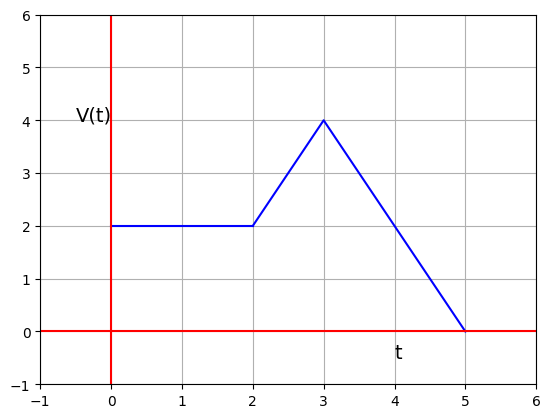

In [130]:
plt.errorbar(x=[0,2],y=[2,2], color="b")
plt.errorbar(x=[2,3,5],y=[2,4,0], color="b")

plt.errorbar(x=[-2,7],y=[0,0], color="r",)
plt.errorbar(x=[0,0],y=[-2,7], color="r",)


plt.text(4,-.5,"t",size=14)
plt.text(-.5,4, "V(t)",size=14)

plt.grid()
plt.ylim(-1,6)
plt.xlim(-1,6)



Quality is Vapor_mass/ ( Total Mass)